## 정확도
- 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
- 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있음

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y = None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1

        return pred

In [ ]:
# 피처를 가공한 내역을 정리한 함수

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Sex', 'Cabin', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1) # row를 drop할 땐 axis = 1
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=0)

# 위에서 생성한 Dummmy Classifier를 이용해 학습/예측/평가 수행

my_clf = MyDummyClassifier()
my_clf.fit(X_train, y_train)

myprediction = my_clf.predict(X_test)
print('Dummy Classifier의 정확도는 : {0:.4f}'.format(accuracy_score(y_test, myprediction)))

Dummy Classifier의 정확도는 : 0.7877


- 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 정확도는 적합한 평가 지표가 아님.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass

    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [ ]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- 정확도는 불균형한 레이블 데이터 세트에서 성능 수치로 사용돼서는 안됨.

## 오차 행렬
- 이진 분류에서 성능 지표로 잘 활용됨
- 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
- 4분면의 행렬에 실제 레이블 클래스와 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄.
- TN : 예측값 N, 실제값 N
- FP : 예측값 P, 실제값 N
- FN : 예측값 N, 실제값 P
- TP : 예측값 P, 실제값 P

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

# TN, FP
# FN, TP

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 정밀도와 재현율

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터 / 테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=11)

lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)

pred = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


### 정밀도 / 재현율 트레이드오프

In [ ]:
# pred_proba

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba() 결과 Shape :', pred_proba.shape)
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한 눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 Class 중 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 Class 중 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [ ]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 작거나 같으면 0, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
from sklearn.preprocessing import Binarizer

# Binarizer 의 threshold 설정값. 분류 결정 임계값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉, 분류 결정 임계값을 0.5에서 0.4로 낮춤

custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) # 임계값이 낮아져 더 많은 값이 Positive로 분류되어 재현율을 높아지지만, 정밀도는 낮아짐.

오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


In [ ]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 : 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197
임계값 : 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869
임계값 : 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705
임계값 : 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377
임계값 : 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213


In [ ]:
from sklearn.metrics import precision_recall_curve # 임계값 변화에 따른 평가 지표 값 변화를 보는 API

# 레이블 값이 1일 때의 예측 확률을 추출

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제 값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape :', thresholds.shape)

# 반환된 임계값 배열 로우가 147 건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임계값 :', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 :', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 :', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape : (165,)
샘플 추출을 위한 임계값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값 : [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도 : [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율 : [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


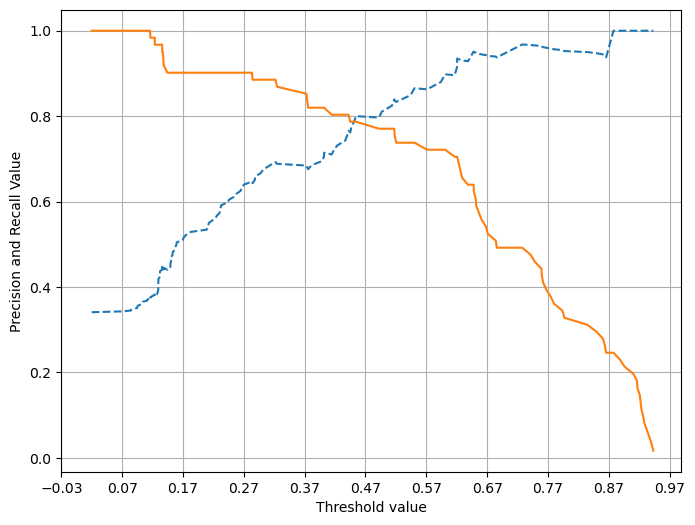

In [ ]:
# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall Value')
    plt.legend; plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## F1 스코어
### F1 = 2 / (1 / Recall + 1 / Precision) = 2 * (precision * recall) / (precision + recall)
- 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7966


In [ ]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # F1 스코어 추가
    f1 = f1_score(y_test, pred)

    print('오차 행렬')
    print(confusion)

    # F1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 : 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197, F1 : 0.7576
임계값 : 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869, F1 : 0.7869
임계값 : 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705, F1 : 0.7966
임계값 : 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377, F1 : 0.7965
임계값 : 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213, F1 : 0.8000


## ROC 곡선과 AUC
#### FPR이 변할 때, TPR이 어떻게 변하는지를 나타내는 곡선

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터 추출하되, 임계값을 5 step으로 추출
# thresholds[0]은 max(예측확률) + 1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)

print('샘플 추출을 위한 임계값 배열의 index :', thr_index)
print('샘플 index로 추출한 임계값 :', np.round(thresholds[thr_index], 2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값 별 FPR :', np.round(fprs[thr_index], 3))
print('샘플 임계값 별 TPR :', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index : [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임계값 : [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값 별 FPR : [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값 별 TPR : [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


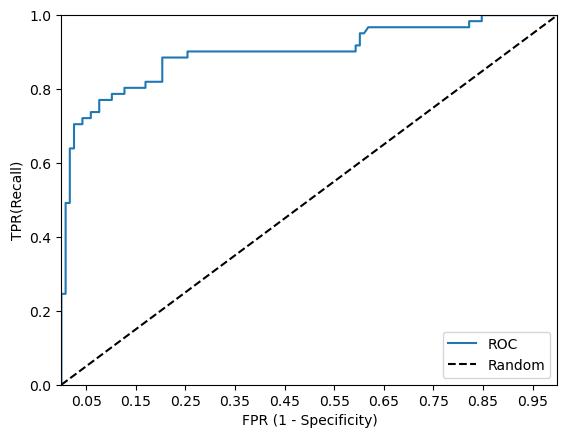

In [ ]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label = 'ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Specificity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

### ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용, 분류의 성능 지표로 사용되는 것은 AUC 값
- AUC 값 = ROC 곡선 밑의 면적, 1에 가까울 수록 좋음

In [ ]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8987


In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC - AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    # ROC - AUC 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


## 피마 인디언 당뇨병 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts()) # Negative가 상대적으로 많음
diabetes_data.head()

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
diabetes_data.info() # Null 값 X, 모두 숫자형, 카테고리형 없음 - 별도의 피처 인코딩 필요하지 않음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba) # 전체 데이터의 65%가 Negative이므로, 정확도보다는 재현율에 초점

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도 : 0.7111, 재현율 : 0.5926, F1 : 0.6465, AUC : 0.8083


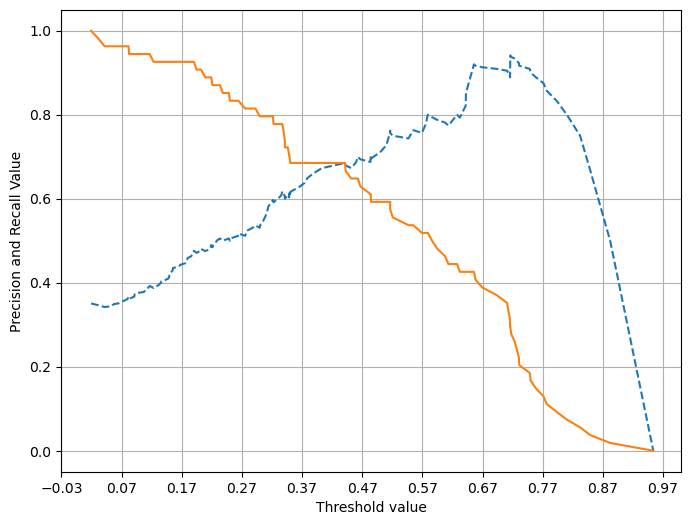

In [ ]:
# 임계값 별 정밀도와 재현율 값의 변화

pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1) # 임계값을 0.42 정도로 낮추면 정밀도와 재현율이 균형을 이루지만, 둘 다 낮음

In [ ]:
# 임계값 조정하기 전에 데이터 값 점검

diabetes_data.describe() # min이 0값이 나오면 안되는 피처에서 0인 값이 많음.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


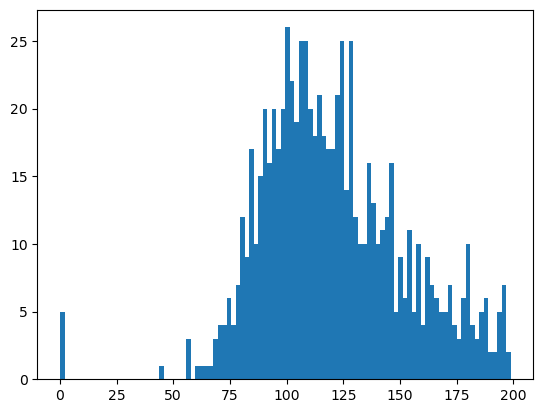

In [ ]:
plt.hist(diabetes_data['Glucose'], bins = 100)
plt.show()

In [ ]:
# 0 값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, zero_count * 100 / total_count ))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [ ]:
# zero_feature 리스트 내부에 저장된 개별 피처들에 대해서 0 값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [ ]:
# 새로운 데이터 세트에 피처 스케일링을 적용.

X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC : 0.8433


In [ ]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :', custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [ ]:
# 임계값을 변화시키면서 재현율 수치 개선
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임계값 : 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도 : 0.7143, 정밀도 : 0.5658, 재현율 : 0.7963, F1 : 0.6615, AUC : 0.8433
임계값 : 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403, 정밀도 : 0.6000, 재현율 : 0.7778, F1 : 0.6774, AUC : 0.8433
임계값 : 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222, F1 : 0.6667, AUC : 0.8433
임계값 : 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037, F1 : 0.6667, AUC : 0.8433
임계값 : 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667, F1 : 0.6792, AUC : 0.8433
임계값 : 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667, F1 : 0.6857, AUC : 0.8433
임계값 : 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1 : 0.6931, AUC : 0.8433
임계값 : 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC : 0.8433


In [ ]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1 : 0.6931, AUC : 0.8433
